## Import the necessary libraries

In [33]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from scipy.signal.windows import hann
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [34]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\AMV Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [35]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [36]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [37]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [38]:
# Split data
train_size = int(len(data_scaled) * 0.7)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [39]:
# Perform FFT with windowing
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies



In [40]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [41]:
# Modify predict_with_trend function
def predict_with_trend(data, fft_result, days, window_size=30):
    # Linear trend
    x = np.arange(window_size)
    trend = np.polyfit(x, data[-window_size:].flatten(), 1)
    trend_func = np.poly1d(trend)
    
    # FFT prediction
    n = len(data)
    if len(fft_result) != n:
        fft_result, _ = fft_transform(data.flatten(), num_frequencies=best_num_freq)
    
    extended_fft = np.zeros(window_size + days, dtype=complex)
    extended_fft[:window_size] = fft_result[-window_size:]
    fft_pred = ifft_transform(extended_fft)[-days:]
    
    # Combine trend and FFT
    trend_pred = trend_func(np.arange(window_size, window_size+days))
    combined_pred = trend_pred + fft_pred
    return np.maximum(combined_pred, 0)  # Ensure non-negative values

In [42]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_with_trend(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")


Best number of frequencies: 5


In [43]:
# Recompute FFT with best number of frequencies
train_fft, _ = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

In [44]:
# Predict for test data using sliding window
window_size = 30
step_size = 7
filtered_test = []

for i in range(0, len(test_data), step_size):
    if i + window_size > len(train_data):
        break
    window_data = np.concatenate((train_data[-window_size:], test_data[:i]))
    window_fft, _ = fft_transform(window_data.flatten(), num_frequencies=best_num_freq)
    pred = predict_with_trend(window_data, window_fft, step_size, window_size)
    filtered_test.extend(pred)

filtered_test = np.array(filtered_test)[:len(test_data)]

In [45]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_with_trend(future_data, future_fft, 30, window_size)
y_next_60_days = predict_with_trend(future_data, future_fft, 60, window_size)
y_next_90_days = predict_with_trend(future_data, future_fft, 90, window_size)

In [46]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 415151028880.5755
RMSE on Test set: 0.08299259371311456
MSLE on Test set: 0.005454737595386553


In [47]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[56393.05706856  2700.         41196.64394913  2700.
 25427.47142168  2700.         10413.4475486   3964.85130763
  2700.         16168.60151211  2700.         25935.04110632
  2700.         33358.28022753  2700.         38872.77391777
  2700.         43103.36115111  2700.         46688.48836474
  2700.         50110.1878501   2700.         53562.81533303
  2700.         56885.33730805  2700.         59570.36689269
  2700.         60849.20783339]

Predicted next 60 days:
[53054.72421307  2700.          2700.         57116.99415438
  2700.          2700.         57452.08516446  2700.
  2700.         54175.32194756  2700.          2700.
 47778.39639684  9131.01485754  2700.         39047.99033838
 20416.52473465  2700.         28944.07829213 29636.85808664
  2700.         18458.32664053 36358.48816911  2700.
  8476.00742518 40494.92320732  2700.          2700.
 42275.01432451  2700.          2700.         42162.49202742
  2700.          2700.         40742.4313456

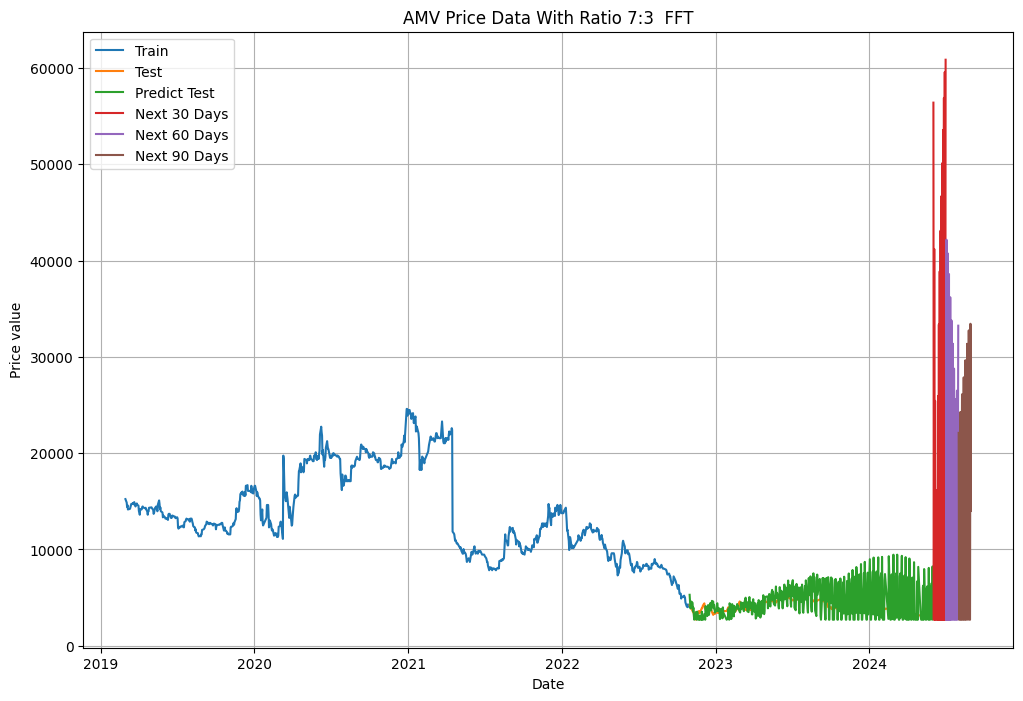

In [48]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("AMV Price Data With Ratio 7:3  FFT")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_73_AMV.png')
plt.show()

## Model 8:2

In [49]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\AMV Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [50]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [51]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [52]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [53]:
# Split data
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [54]:
# Perform FFT with windowing
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies


In [55]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [56]:
# Modify predict_with_trend function
def predict_with_trend(data, fft_result, days, window_size=30):
    # Linear trend
    x = np.arange(window_size)
    trend = np.polyfit(x, data[-window_size:].flatten(), 1)
    trend_func = np.poly1d(trend)
    
    # FFT prediction
    n = len(data)
    if len(fft_result) != n:
        fft_result, _ = fft_transform(data.flatten(), num_frequencies=best_num_freq)
    
    extended_fft = np.zeros(window_size + days, dtype=complex)
    extended_fft[:window_size] = fft_result[-window_size:]
    fft_pred = ifft_transform(extended_fft)[-days:]
    
    # Combine trend and FFT
    trend_pred = trend_func(np.arange(window_size, window_size+days))
    combined_pred = trend_pred + fft_pred
    return np.maximum(combined_pred, 0)  # Ensure non-negative values

In [57]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_with_trend(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")


Best number of frequencies: 5


In [58]:
# Recompute FFT with best number of frequencies
train_fft, _ = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

In [59]:
# Predict for test data using sliding window
window_size = 30
step_size = 7
filtered_test = []

for i in range(0, len(test_data), step_size):
    if i + window_size > len(train_data):
        break
    window_data = np.concatenate((train_data[-window_size:], test_data[:i]))
    window_fft, _ = fft_transform(window_data.flatten(), num_frequencies=best_num_freq)
    pred = predict_with_trend(window_data, window_fft, step_size, window_size)
    filtered_test.extend(pred)

filtered_test = np.array(filtered_test)[:len(test_data)]

In [60]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_with_trend(future_data, future_fft, 30, window_size)
y_next_60_days = predict_with_trend(future_data, future_fft, 60, window_size)
y_next_90_days = predict_with_trend(future_data, future_fft, 90, window_size)

In [61]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.9657239829343143
RMSE on Test set: 0.059507905493464616
MSLE on Test set: 0.003002225589092155


In [62]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[56393.05706856  2700.         41196.64394913  2700.
 25427.47142168  2700.         10413.4475486   3964.85130763
  2700.         16168.60151211  2700.         25935.04110632
  2700.         33358.28022753  2700.         38872.77391777
  2700.         43103.36115111  2700.         46688.48836474
  2700.         50110.1878501   2700.         53562.81533303
  2700.         56885.33730805  2700.         59570.36689269
  2700.         60849.20783339]

Predicted next 60 days:
[53054.72421307  2700.          2700.         57116.99415438
  2700.          2700.         57452.08516446  2700.
  2700.         54175.32194756  2700.          2700.
 47778.39639684  9131.01485754  2700.         39047.99033838
 20416.52473465  2700.         28944.07829213 29636.85808664
  2700.         18458.32664053 36358.48816911  2700.
  8476.00742518 40494.92320732  2700.          2700.
 42275.01432451  2700.          2700.         42162.49202742
  2700.          2700.         40742.4313456

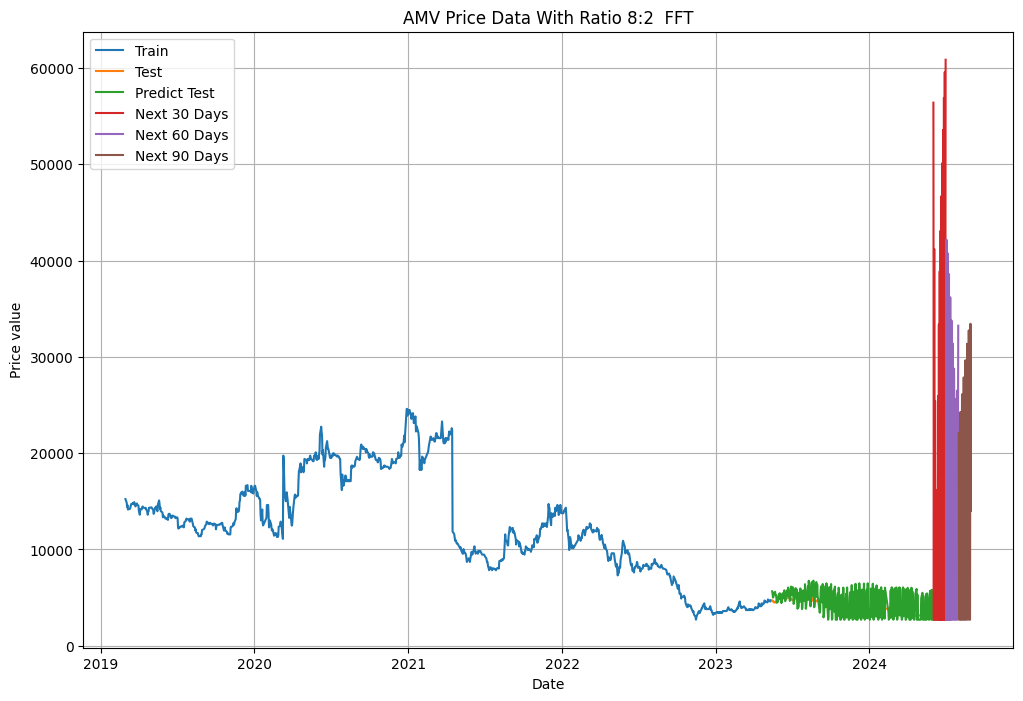

In [63]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("AMV Price Data With Ratio 8:2  FFT")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_82_AMV.png')
plt.show()

## Model 9:1

In [64]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\AMV Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [65]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [66]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [67]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [68]:
# Split data
train_size = int(len(data_scaled) * 0.9)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [69]:
# Perform FFT with windowing
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies


In [70]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [71]:
# Modify predict_with_trend function
def predict_with_trend(data, fft_result, days, window_size=30):
    # Linear trend
    x = np.arange(window_size)
    trend = np.polyfit(x, data[-window_size:].flatten(), 1)
    trend_func = np.poly1d(trend)
    
    # FFT prediction
    n = len(data)
    if len(fft_result) != n:
        fft_result, _ = fft_transform(data.flatten(), num_frequencies=best_num_freq)
    
    extended_fft = np.zeros(window_size + days, dtype=complex)
    extended_fft[:window_size] = fft_result[-window_size:]
    fft_pred = ifft_transform(extended_fft)[-days:]
    
    # Combine trend and FFT
    trend_pred = trend_func(np.arange(window_size, window_size+days))
    combined_pred = trend_pred + fft_pred
    return np.maximum(combined_pred, 0)  # Ensure non-negative values

In [72]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_with_trend(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")


Best number of frequencies: 5


In [73]:
# Recompute FFT with best number of frequencies
train_fft, _ = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

In [74]:
# Predict for test data using sliding window
window_size = 30
step_size = 7
filtered_test = []

for i in range(0, len(test_data), step_size):
    if i + window_size > len(train_data):
        break
    window_data = np.concatenate((train_data[-window_size:], test_data[:i]))
    window_fft, _ = fft_transform(window_data.flatten(), num_frequencies=best_num_freq)
    pred = predict_with_trend(window_data, window_fft, step_size, window_size)
    filtered_test.extend(pred)

filtered_test = np.array(filtered_test)[:len(test_data)]

In [75]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_with_trend(future_data, future_fft, 30, window_size)
y_next_60_days = predict_with_trend(future_data, future_fft, 60, window_size)
y_next_90_days = predict_with_trend(future_data, future_fft, 90, window_size)

In [76]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.5279524540979529
RMSE on Test set: 0.025901026036934
MSLE on Test set: 0.000606580300174941


In [77]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[56393.05706856  2700.         41196.64394913  2700.
 25427.47142168  2700.         10413.4475486   3964.85130763
  2700.         16168.60151211  2700.         25935.04110632
  2700.         33358.28022753  2700.         38872.77391777
  2700.         43103.36115111  2700.         46688.48836474
  2700.         50110.1878501   2700.         53562.81533303
  2700.         56885.33730805  2700.         59570.36689269
  2700.         60849.20783339]

Predicted next 60 days:
[53054.72421307  2700.          2700.         57116.99415438
  2700.          2700.         57452.08516446  2700.
  2700.         54175.32194756  2700.          2700.
 47778.39639684  9131.01485754  2700.         39047.99033838
 20416.52473465  2700.         28944.07829213 29636.85808664
  2700.         18458.32664053 36358.48816911  2700.
  8476.00742518 40494.92320732  2700.          2700.
 42275.01432451  2700.          2700.         42162.49202742
  2700.          2700.         40742.4313456

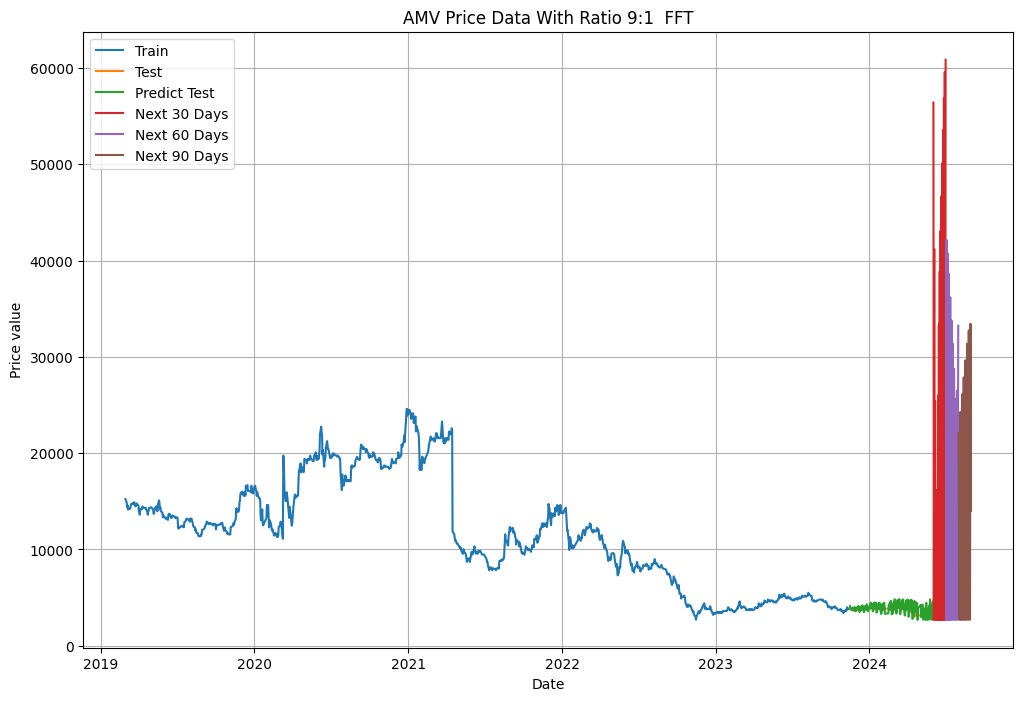

In [78]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("AMV Price Data With Ratio 9:1  FFT")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_91_AMV.png')
plt.show()